In [1]:
# import libraries
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re

In [2]:
elon_df = pd.read_csv("TweetsElonMusk.csv")
elon_df.head(1)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1381273474400800773,1381002894032347138,2021-04-11 18:50:33 EEST,2021-04-11,18:50:33,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vincent13031925', 'name': 'V...",NaN,NaN,NaN,NaN


In [3]:
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12562 entries, 0 to 12561
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               12562 non-null  int64  
 1   conversation_id  12562 non-null  int64  
 2   created_at       12562 non-null  object 
 3   date             12562 non-null  object 
 4   time             12562 non-null  object 
 5   timezone         12562 non-null  int64  
 6   user_id          12562 non-null  int64  
 7   username         12562 non-null  object 
 8   name             12562 non-null  object 
 9   place            0 non-null      float64
 10  tweet            12562 non-null  object 
 11  language         12562 non-null  object 
 12  mentions         12562 non-null  object 
 13  urls             12562 non-null  object 
 14  photos           12562 non-null  object 
 15  replies_count    12562 non-null  int64  
 16  retweets_count   12562 non-null  int64  
 17  likes_count 

# Clean Phase

In [4]:
# Remove duplicates
elon_df = elon_df.drop_duplicates()

In [5]:
# Drop unnecessary columns
columns_to_drop = ["conversation_id", "timezone", "place", "mentions", "urls", "photos", "cashtags", "link", "retweet", "quote_url", "video", "thumbnail", "near", "geo", "source", "user_rt_id", "user_rt", "retweet_id", "reply_to", "retweet_date", "translate", "trans_src", "trans_dest"]
elon_df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# Handling with Missing Values
## Count missing values in each column
missing_values = elon_df.isna().sum()

## Display the count of missing values
print(missing_values)

## Total count of missing values
total_missing = elon_df.isna().sum().sum()

## Display the total count of missing values
print("Total missing values:", total_missing)

## Drop rows with any missing values
elon_df.dropna(inplace=True)

print("\033[96m===========After dropping rows with missing values:=========================")
total_missing = elon_df.isna().sum().sum()
print("\033[91mTotal missing values: \033[0m", total_missing)

id                0
created_at        0
date              0
time              0
user_id           0
username          0
name              0
tweet             0
language          0
replies_count     0
retweets_count    0
likes_count       0
hashtags          0
dtype: int64
Total missing values: 0
===========After dropping rows with missing values:=========================
Total missing values:  0


In [7]:
# Convert date and time columns to datetime objects
elon_df['created_at'] = pd.to_datetime(elon_df['created_at'], format='mixed')
elon_df['date'] = pd.to_datetime(elon_df['date'])
elon_df['time'] = pd.to_datetime(elon_df['time'], errors='coerce')

C:\Users\Ayman Adel\AppData\Local\Temp\ipykernel_8328\1717694289.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  elon_df['time'] = pd.to_datetime(elon_df['time'], errors='coerce')


In [8]:
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12562 entries, 0 to 12561
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              12562 non-null  int64         
 1   created_at      12562 non-null  datetime64[ns]
 2   date            12562 non-null  datetime64[ns]
 3   time            12562 non-null  datetime64[ns]
 4   user_id         12562 non-null  int64         
 5   username        12562 non-null  object        
 6   name            12562 non-null  object        
 7   tweet           12562 non-null  object        
 8   language        12562 non-null  object        
 9   replies_count   12562 non-null  int64         
 10  retweets_count  12562 non-null  int64         
 11  likes_count     12562 non-null  int64         
 12  hashtags        12562 non-null  object        
dtypes: datetime64[ns](3), int64(5), object(5)
memory usage: 1.2+ MB


In [9]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and emojis
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    sw = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in sw]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the clean_text function to the 'tweet' column
elon_df['clean_tweet'] = elon_df['tweet'].apply(clean_text)

# Filtering tweets containing specific words
elon_df = elon_df[elon_df['clean_tweet'].str.contains('btc|bitcoin|crypto|blockchain|currency|mining', case=False)]

# Print the cleaned tweets
print(elon_df['clean_tweet'])

24                                            memescryptor
162      pay bitcoin capability available outside u lat...
163      tesla using internal amp open source software ...
164                                      buy tesla bitcoin
243                         mining amp use block amp chain
244      btc bitcoin anagram tbcthe boring company coin...
324                            scammer amp crypto get room
393                               cryptocurrency explained
395                 heard rumor crypto coin pegging dollar
399            dogecoin set little doge mining rig kid fun
401             peterschiff said btc amp eth seem high lol
402      peterschiff email saying gold gold might well ...
409      realfuckingnews business somehow hash text fil...
410      business clear investor engineer dont even pub...
411      business tesla action directly reflective opin...
458      freewalletorg crypto wallet wont give private ...
467              cryptoshrikar coindesk tesla dan_z_palm

<function matplotlib.pyplot.show(close=None, block=None)>

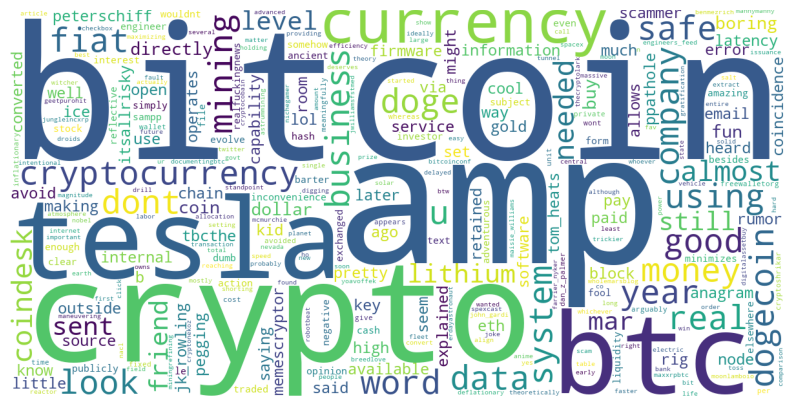

In [11]:
# Collecting text from each tweet
texts = elon_df['clean_tweet']
text = " ".join(i for i in texts)

# Generate and display a WordCloud visualization for tweets.
wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

# Sentiment Analysis

In [12]:
# A textblob function that will read tweets, and create a column of noun phrases, polarity, and subjectivity
def add_tb_data(df: DataFrame, attrs: List[str]) -> DataFrame:
    def get_tb_attr(tweet, _attr: str):
        tb = TextBlob(tweet)
        return tb.__getattribute__(_attr)
    
    for attr in attrs:
        df[attr] = df['clean_tweet'].apply(get_tb_attr, _attr=attr)

    return df

In [13]:
# Dataframe for the columns we need
elon_df = elon_df[['id', 'clean_tweet', 'date']]
# These will be used for the textblob function
tb_attributes = ['noun_phrases', 'polarity', 'subjectivity']
# Run the new function on our database, create attribute columns, then populate them with phrases and values
elon_df = add_tb_data(elon_df, tb_attributes)

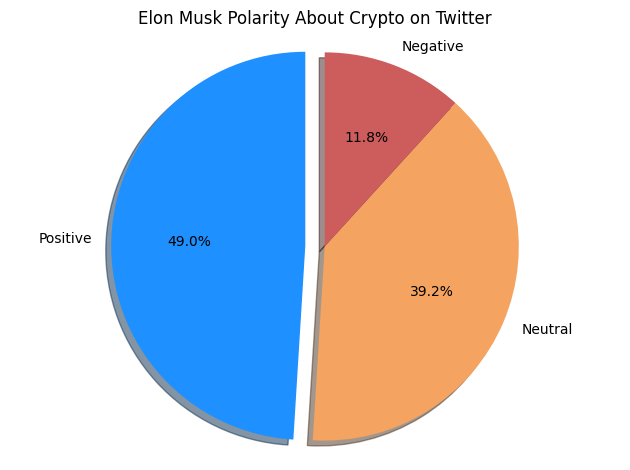

In [14]:
# labelizing the added attributes and plot results
polarity_df = elon_df['polarity']
positive_count = polarity_df[polarity_df > 0].count()
neutral_count = polarity_df[polarity_df ==0].count()
negative_count = polarity_df[polarity_df < 0].count()

labels = 'Positive', "Neutral",'Negative'
polarity = [positive_count,neutral_count ,negative_count]
explode = (0.1,0 ,0)

fig1, ax1 = plt.subplots()
ax1.pie(polarity, explode=explode, labels=labels ,colors=['#1E90FF','#F4A460','#CD5C5C'],autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Elon Musk Polarity About Crypto on Twitter')

plt.tight_layout()
plt.show()


# BTC DB

In [15]:
# Read bitcoin csv database
btc_df = pd.read_csv("BTC-Daily.csv",low_memory=False)

In [16]:
# show first 5 rows
btc_df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,3/1/2022 0:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2/28/2022 0:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2/27/2022 0:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2/26/2022 0:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2/25/2022 0:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


# Clean Data

In [17]:
# Filtering needed columns
btc_df = btc_df[['date','open','high','low','close']]

# converting date column to a datetime
btc_df['date'] = pd.to_datetime(btc_df['date'])

# filtering bitcoin data to be in range same as the elon data
start_date=pd.to_datetime(f"{elon_df['date'].min()}")
end_date = pd.to_datetime(f"{elon_df['date'].max()}")
btc_df = btc_df[(btc_df['date'] >= start_date) & (btc_df['date'] <= end_date)]

In [47]:
#Show the first 5 rows of data
btc_df.head()

,date,open,high,low,close
325,2021-04-10,58129.02,61222.22,57870.00,59766.93
326,2021-04-09,58066.18,58890.25,57657.43,58109.56
327,2021-04-08,55912.38,58145.49,55680.40,58096.60
328,2021-04-07,58024.90,58668.00,55441.93,55932.83
329,2021-04-06,59135.36,59473.90,57216.00,58018.30


In [19]:
# Merging the modified Elon Musk data with Bitcoin data 
merged_data = pd.merge(btc_df, elon_df, on='date', how='inner')

In [49]:
# Show first 5 rows
merged_data.head()

,date,open,high,low,close,id,clean_tweet,noun_phrases,polarity,subjectivity
0,2021-04-10,58129.02,61222.22,57870.00,59766.93,1380773639038111751,memescryptor,[],0.000000,0.00
1,2021-03-24,54360.07,57207.33,51638.76,52287.52,1374619672973221892,pay bitcoin capability available outside u lat...,[bitcoin capability],0.133333,0.15
2,2021-03-24,54360.07,57207.33,51638.76,52287.52,1374619379929772034,tesla using internal amp open source software ...,"[internal amp, open source software amp, bitco...",0.033333,0.30
3,2021-03-24,54360.07,57207.33,51638.76,52287.52,1374617643446063105,buy tesla bitcoin,[tesla bitcoin],0.000000,0.00
4,2021-03-12,57847.92,58098.50,55011.00,57271.04,1370449655855788044,mining amp use block amp chain,[amp use block amp chain],0.000000,0.00


In [20]:
# Select features and target variable for modeling
X = merged_data[['polarity','high','low','open']]
y = merged_data['close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Assuming X_train and y_train are already defined and contain your training data
grid_search.fit(X_train, y_train)

# Best parameters found

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae.round(4)} $')
print(f'R^2 Score: {r2.round(4)}')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Absolute Error: 902.0751 $
R^2 Score: 0.9926


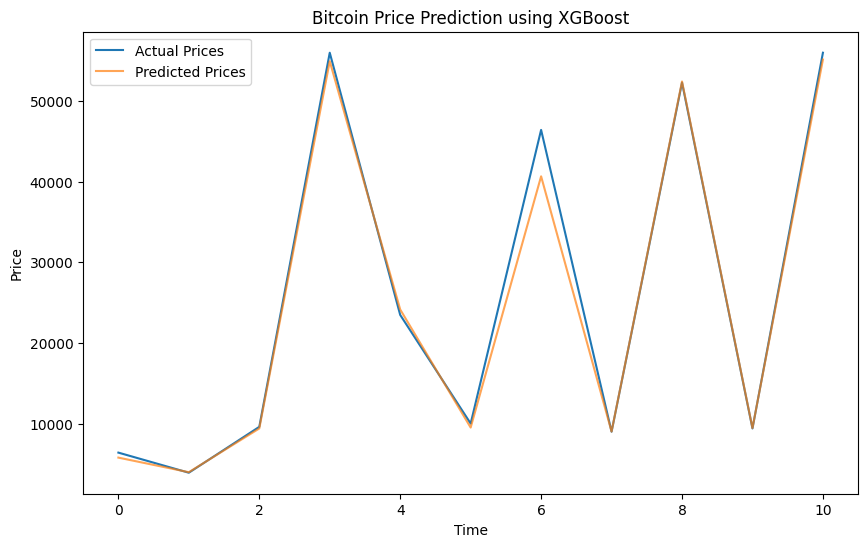

In [21]:
# Plot the actual vs. predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', alpha=0.7)
plt.legend()
plt.title('Bitcoin Price Prediction using XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
